## Assignment: $k$ Means Clustering

## **Do two questions.**

`! git clone https://www.github.com/DS3001/kmc`

In [1]:
! git clone https://www.github.com/DS3001/kmc

Cloning into 'kmc'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 25 (delta 4), reused 3 (delta 3), pack-reused 18
Receiving objects: 100% (25/25), 5.04 MiB | 19.13 MiB/s, done.
Resolving deltas: 100% (4/4), done.


**Q1.** This question is a case study for $k$ means clustering.

1. Load the `airbnb_hw.csv` data. Clean `Price` along with `Beds`, `Number of Reviews`, and `Review Scores Rating`.
2. Maxmin normalize the data and remove any `nan`'s (`KMeans` from `sklearn` doesn't accept `nan` input).
3. Use `sklearn`'s `KMeans` module to cluster the data by `Beds`, `Number of Reviews`, and `Review Scores Rating` for `k=6`.
4. Use `seaborn`'s `.pairplot()` to make a grid of scatterplots that show how the clustering is carried out in multiple dimensions.
5. Use `.groupby` and `.describe` to compute the average price for each cluster. Which clusters have the highest rental prices?
6. Use a scree plot to pick the number of clusters and repeat steps 4 and 5.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
df= pd.read_csv("/content/kmc/data/airbnb_hw.csv")
df['n_rev'] = df['Number Of Reviews']
df['score'] = df['Review Scores Rating']
X = df.loc[:,['Price','Beds','n_rev','score']]
print(X.shape)
X.describe()

(30478, 4)


,Beds,n_rev,score
count,30393.000000,30478.000000,22155.000000
mean,1.530089,12.018735,91.993230
std,1.015359,21.980703,8.850373
min,0.000000,0.000000,20.000000
25%,1.000000,0.000000,89.000000
50%,1.000000,3.000000,94.000000
75%,2.000000,13.000000,100.000000
max,16.000000,257.000000,100.000000


In [18]:
X['Price'].value_counts()

150      1481
100      1207
200      1059
125       889
75        873
         ... 
840         1
306         1
2,695       1
2,520       1
291         1
Name: Price, Length: 511, dtype: int64

In [19]:
X['Price'] = X['Price'].str.replace(',','')
X['Price'] = pd.to_numeric(X['Price'],errors='coerce')
X['Price'] = X['Price'].fillna(1)

In [20]:
X['Price'].value_counts()

150     1481
100     1207
200     1059
125      889
75       873
        ... 
840        1
306        1
2695       1
2520       1
291        1
Name: Price, Length: 511, dtype: int64

In [21]:
X['Beds'].value_counts()

1.0     20344
2.0      6610
3.0      2071
4.0       783
5.0       284
6.0       177
7.0        45
8.0        24
10.0       16
9.0        15
16.0       13
11.0        5
12.0        4
0.0         2
Name: Beds, dtype: int64

In [22]:
X['Beds'] = X['Beds'].fillna(1)

In [23]:
X['n_rev'].value_counts()

0      7814
1      3572
2      2457
3      1764
4      1382
       ... 
216       1
191       1
213       1
178       1
130       1
Name: n_rev, Length: 205, dtype: int64

In [24]:
X = X.dropna()

In [27]:
def maxmin(x):
    u = (x-min(x))/(max(x)-min(x))
    return u
Z = X.drop('Price',axis=1)
Z = Z.apply(maxmin)

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [33]:
model = KMeans(n_clusters=8, max_iter=300, n_init = 10, random_state=0)
model = model.fit(Z)
Z['cluster'] = model.labels_

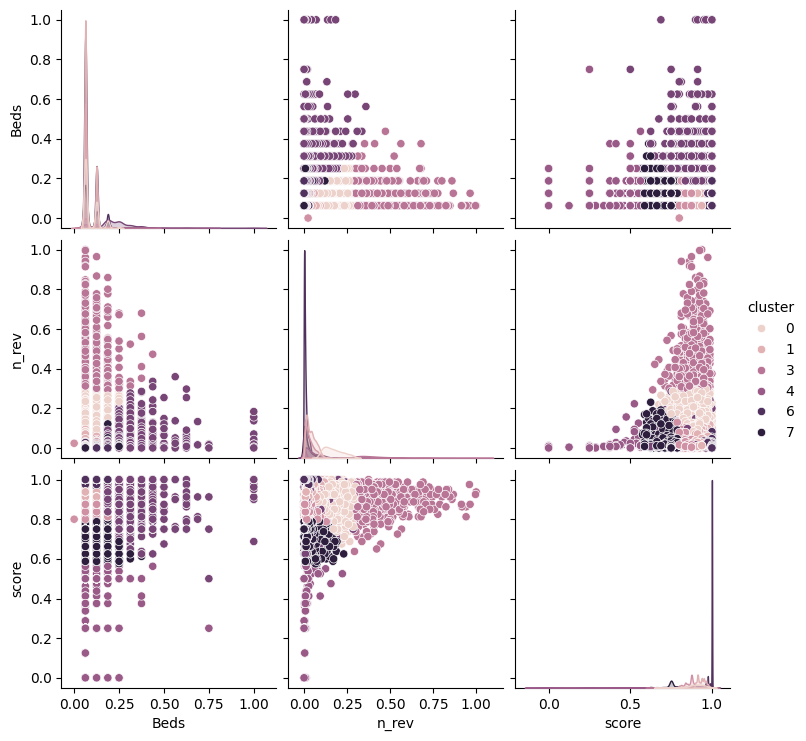

In [34]:
import seaborn as sns
sns.pairplot(data=Z,hue='cluster')

In [30]:
X['cluster'] = model.labels_
X.loc[:,['Price','cluster'] ].groupby('cluster').describe()

Price                                                              
           count        mean         std   min     25%    50%     75%      max
cluster                                                                       
0          794.0  133.238035   83.077776  27.0   80.00  110.0  168.50    875.0
1        10512.0  152.233352  147.281729  10.0   85.00  130.0  190.00  10000.0
2         5554.0  131.496579  102.621585  20.0   75.00  110.0  169.00   5000.0
3          632.0  133.587025  215.505565  25.0   65.00   99.0  151.25   5000.0
4         1633.0  293.458665  262.439199  27.0  150.00  229.0  350.00   4500.0
5         3030.0  141.674917   84.134011  22.0   87.25  125.0  175.00   1000.0

Clusters 3 seems to have the highest mean by some distance, with the rest seemingly similar. Of those, cluster 1 is also high.

Text(0.5, 1.0, 'Scree Plot')

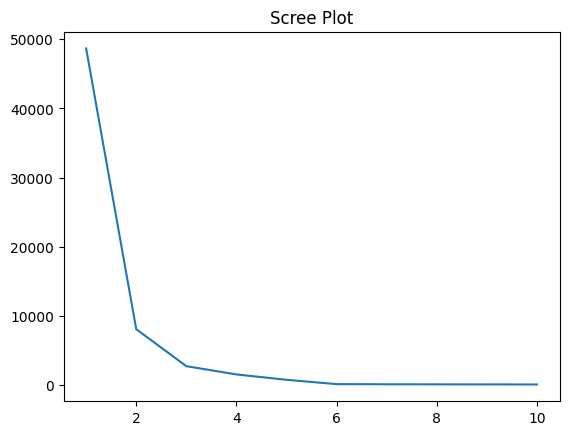

In [31]:
k_bar =10
k_grid = np.arange(1,k_bar+1)
SSE = np.zeros(k_bar)
for k in range(k_bar):
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0)
    model = model.fit(Z)
    SSE[k] = model.inertia_
sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot')

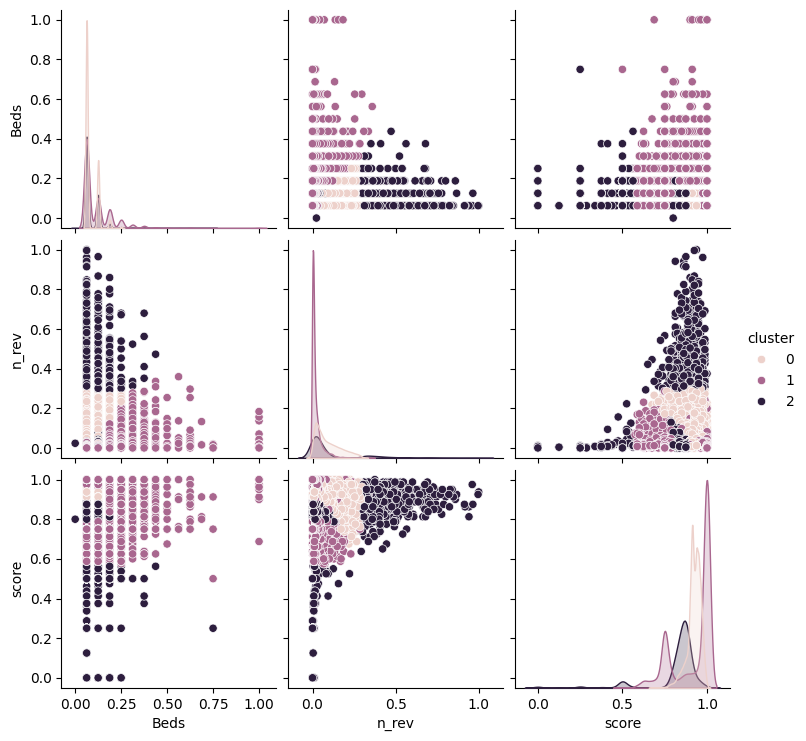

In [36]:
model = KMeans(n_clusters=3, max_iter=300, n_init = 10, random_state=0)
model = model.fit(Z)
Z['cluster'] = model.labels_
sns.pairplot(data=Z,hue='cluster')



**Q2.** This is a question about $k$ means clustering. We want to investigate how adjusting the "noisiness" of the data impacts the quality of the algorithm and the difficulty of picking $k$.

1. Run the code below, which creates four datasets: `df0_125`, `df0_25`, `df0_5`, `df1_0`, and `df2_0`. Each data set is created by increasing the amount of `noise` (standard deviation) around the cluster centers, from `0.125` to `0.25` to `0.5` to `1.0` to `2.0`.

```
import numpy as np
import pandas as pd

def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,noise,N),np.random.normal(1,noise,N)])
    X2 = np.array([np.random.normal(3,noise,N),np.random.normal(2,noise,N)])
    X3 = np.array([np.random.normal(5,noise,N),np.random.normal(3,noise,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)
```

2. Make scatterplots of the $(X1,X2)$ points by group for each of the datasets. As the `noise` goes up from 0.125 to 2.0, what happens to the visual distinctness of the clusters?
3. Create a scree plot for each of the datasets. Describe how the level of `noise` affects the scree plot (particularly the presence of a clear "elbow") and your ability to definitively select a $k$.
4. Explain the intuition of the elbow, using this numerical simulation as an example.

In [37]:
def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,noise,N),np.random.normal(1,noise,N)])
    X2 = np.array([np.random.normal(3,noise,N),np.random.normal(2,noise,N)])
    X3 = np.array([np.random.normal(5,noise,N),np.random.normal(3,noise,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)

<Axes: xlabel='x1', ylabel='x2'>

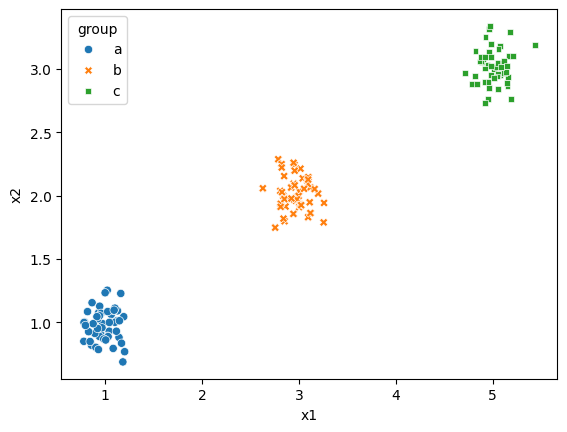

In [38]:
sns.scatterplot(data = df0_125, x = 'x1',y='x2',hue='group',style='group')

<Axes: xlabel='x1', ylabel='x2'>

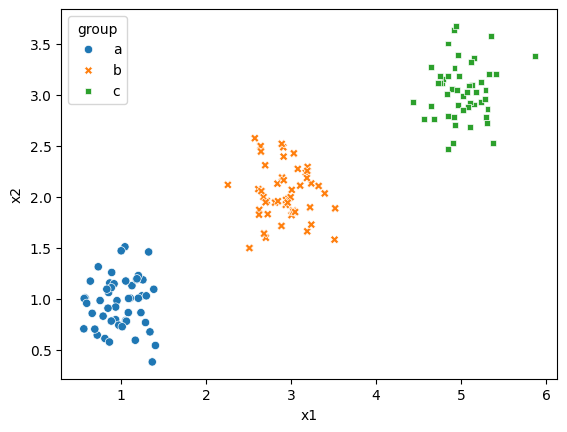

In [39]:
sns.scatterplot(data = df0_25, x = 'x1',y='x2',hue='group',style='group')

<Axes: xlabel='x1', ylabel='x2'>

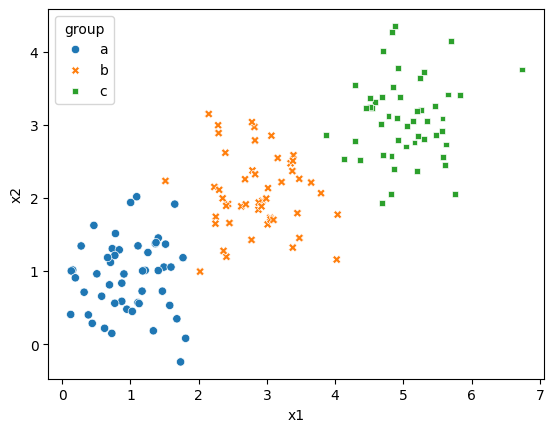

In [40]:
sns.scatterplot(data = df0_5, x = 'x1',y='x2',hue='group',style='group')

<Axes: xlabel='x1', ylabel='x2'>

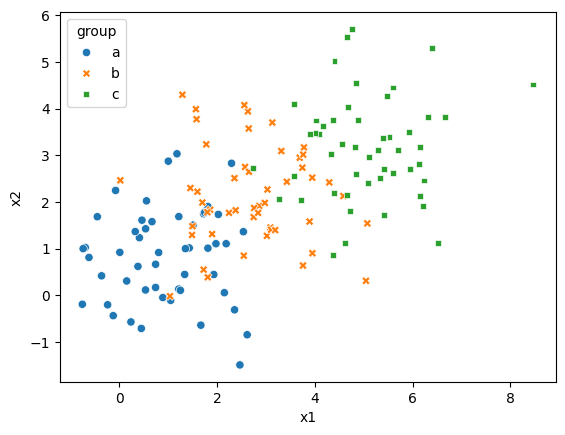

In [41]:
sns.scatterplot(data = df1_0, x = 'x1',y='x2',hue='group',style='group')

<Axes: xlabel='x1', ylabel='x2'>

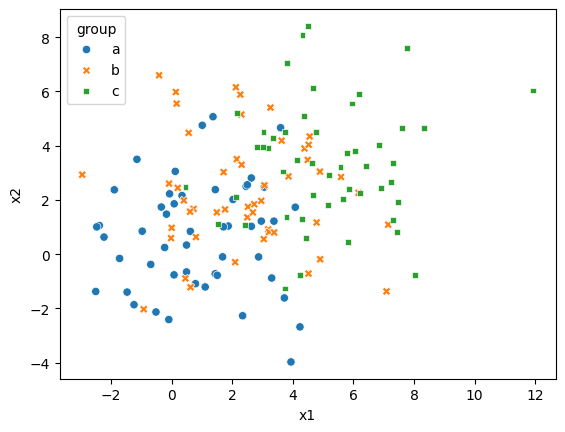

In [42]:
sns.scatterplot(data = df2_0, x = 'x1',y='x2',hue='group',style='group')

As the noise increases, the clusters begin to disperse and become less defined.

(0.0, 35.0)

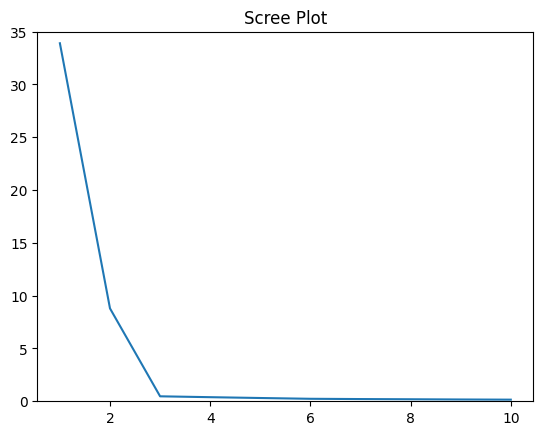

In [46]:
def maxmin(x):
    x = (x-min(x))/(max(x)-min(x))
    return x

X = df0_125.loc[ : , ['x1','x2'] ]
X = X.apply(maxmin)
k_bar = 10
k_grid = np.arange(1,k_bar+1)
SSE = np.zeros(k_bar)
for k in range(k_bar):
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0)
    model = model.fit(X)
    SSE[k] = model.inertia_
scree_plot, axes = plt.subplots()
sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot')
axes.set_ylim(0, 35)

(0.0, 28.0)

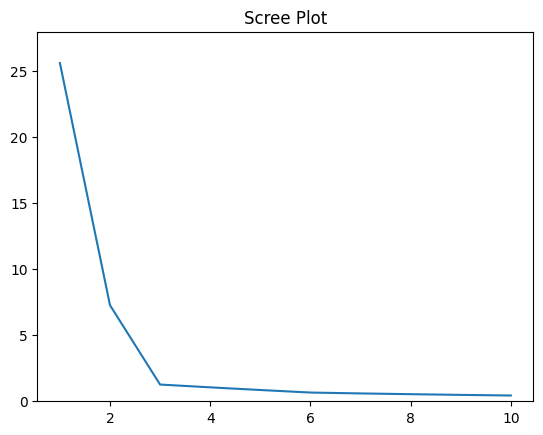

In [48]:
def maxmin(x):
    x = (x-min(x))/(max(x)-min(x))
    return x

X = df0_25.loc[ : , ['x1','x2'] ]
X = X.apply(maxmin)
k_bar = 10
k_grid = np.arange(1,k_bar+1)
SSE = np.zeros(k_bar)
for k in range(k_bar):
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0)
    model = model.fit(X)
    SSE[k] = model.inertia_
scree_plot, axes = plt.subplots()
sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot')
axes.set_ylim(0, 28)

(0.0, 20.0)

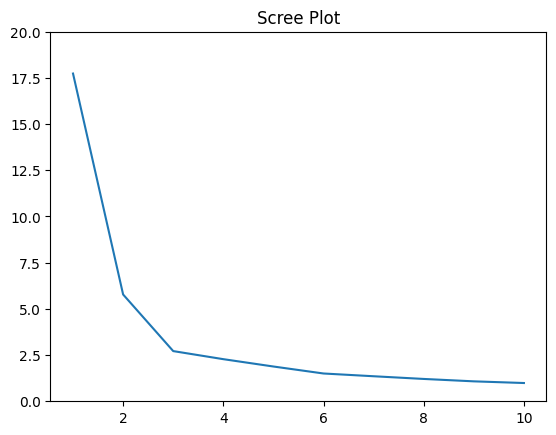

In [50]:
def maxmin(x):
    x = (x-min(x))/(max(x)-min(x))
    return x

X = df0_5.loc[ : , ['x1','x2'] ]
X = X.apply(maxmin)
k_bar = 10
k_grid = np.arange(1,k_bar+1)
SSE = np.zeros(k_bar)
for k in range(k_bar):
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0)
    model = model.fit(X)
    SSE[k] = model.inertia_
scree_plot, axes = plt.subplots()
sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot')
axes.set_ylim(0, 20)

(0.0, 15.0)

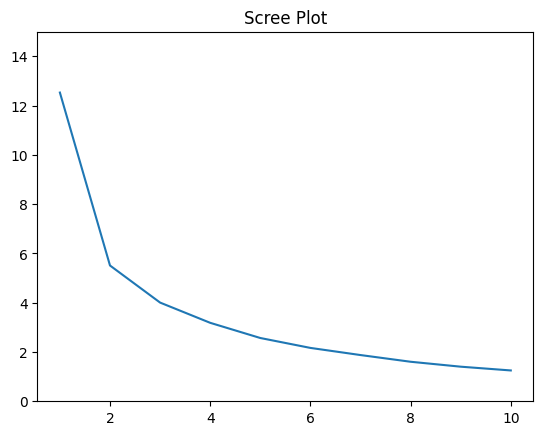

In [52]:
def maxmin(x):
    x = (x-min(x))/(max(x)-min(x))
    return x

X = df1_0.loc[ : , ['x1','x2'] ]
X = X.apply(maxmin)
k_bar = 10
k_grid = np.arange(1,k_bar+1)
SSE = np.zeros(k_bar)
for k in range(k_bar):
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0)
    model = model.fit(X)
    SSE[k] = model.inertia_
scree_plot, axes = plt.subplots()
sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot')
axes.set_ylim(0, 15)

(0.0, 15.0)

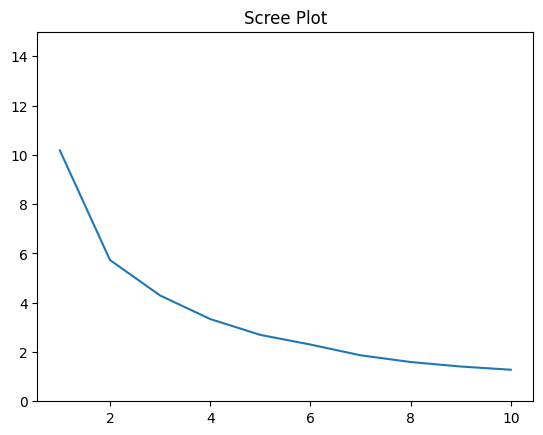

In [53]:
def maxmin(x):
    x = (x-min(x))/(max(x)-min(x))
    return x

X = df2_0.loc[ : , ['x1','x2'] ]
X = X.apply(maxmin)
k_bar = 10
k_grid = np.arange(1,k_bar+1)
SSE = np.zeros(k_bar)
for k in range(k_bar):
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0)
    model = model.fit(X)
    SSE[k] = model.inertia_
scree_plot, axes = plt.subplots()
sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot')
axes.set_ylim(0, 15)

The max noises levels lack a clear elbow shape, however for lower noise levels there is a distinct shape visible.

The implementation of a scree plot is an intuitive way to find the optimal k value, or number of clusters. This works by providing the user with a plot which represents the distint clustering patterns of the k values. When the groups are clearly isolated, a elbow shape will appear in the scree plot. Alternatively, if the clusters show no visible patterns, a messy elbow with lack of definition. This is shown in our example, where the lower noise levels with distinct scatterplot clusters also are represented with distinct elbow scree plots.

**Q3.** We looked at computer vision with $k$NN in a previous question. Can $k$ means clustering correctly group digits, even if we don't know which symbols are which?

1. To load the data, run the following code in a chunk:
```
from keras.datasets import mnist
df = mnist.load_data('minst.db')
train,test = df
X_train, y_train = train
X_test, y_test = test
```
The `y_test` and `y_train` vectors, for each index `i`, tell you want number is written in the corresponding index in `X_train[i]` and `X_test[i]`. The value of `X_train[i]` and `X_test[i]`, however, is a 28$\times$28 array whose entries contain values between 0 and 256. Each element of the matrix is essentially a "pixel" and the matrix encodes a representation of a number. To visualize this, run the following code to see the first ten numbers:
```
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
for i in range(5):
    print(y_test[i],'\n') # Print the label
    print(X_test[i],'\n') # Print the matrix of values
    plt.contourf(np.rot90(X_test[i].transpose())) # Make a contour plot of the matrix values
    plt.show()
```
OK, those are the data: Labels attached to handwritten digits encoded as a matrix.

2. What is the shape of `X_train` and `X_test`? What is the shape of `X_train[i]` and `X_test[i]` for each index `i`? What is the shape of `y_train` and `y_test`?
3. Use Numpy's `.reshape()` method to covert the training and testing data from a matrix into an vector of features. So, `X_test[index].reshape((1,784))` will convert the $index$-th element of `X_test` into a $28\times 28=784$-length row vector of values, rather than a matrix. Turn `X_train` into an $N \times 784$ matrix $X$ that is suitable for scikit-learn's kNN classifier where $N$ is the number of observations and $784=28*28$ (you could use, for example, a `for` loop).
4. Use $k$ means clustering on the reshaped `X_test` data with `k=10`.  
5. Cross tabulate the cluster assignments with the true labels for the test set values. How good is the correspondence? What proportion of digits are clustered correctly? Which digits are the hardest to distinguish from one another? Can $k$MC recover the latent digits 0 to 9, without even knowing what those digits were?
6. If you use a scree plot to determine the number of clusters $k$, does it pick 10 (the true number of digits), or not? If it fails to pick $k=10$, which digits does it tend to combine into the same classification?